In [1]:
# Show plots inline, and load main getdist plot module and samples class
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
import pylab as mplot
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True



%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.figsize'] = (16.,8.)
#import config

from chainconsumer import ChainConsumer


GetDist Version: 1.3.4, Matplotlib version: 3.1.1


In [2]:
def get_names(filename):
    """
    Function to obtain the names of the parameters of your chain
    """
    data = np.genfromtxt(filename, names=True)
    names = np.array(data.dtype.names)
    #print(names)
    #print(len(names))
    return names

def get_indices(filename, list_vars):
    """
    Function to obtain the index in a multinest chain from certain variables.
    """
    indices = []
    names = get_names(filename)
    for var in list_vars:
        indices.extend([i for i,n in enumerate(names) if var==n])
    #return indices, names[indices]
    return indices

def get_om_s8(filename):
    # might be useful later..
    data = np.loadtxt(filename)
    nsample = get_nsample(filename)
    data_params = []
    data_params.append([data[-nsample:,0], data[-nsample:,-3]*(data[-nsample:,0]/0.3)**(0.5)])
    data_params = np.array(data_params[0][:]).T
    weights = data[-nsample:,-1]
    return data_params, weights

def compute_s8(om, sigma_8):
    return sigma_8*(om/0.3)**0.5

In [3]:
dir = '../../data_vectors/gaussian_sims/071222/area12300/July14/chains/'
nlbins = 5

name_plots = 'tjpcov-vs-fsky'

chainfile_0 = dir + 'gaussian_sims_3x2pt_fourier_lcdm.txt'
name_0 = r'$f_\mathrm{sky}$'

chainfile_1 = dir + 'gaussian_sims_3x2pt_fourier_lcdm_tjpcov.txt'
name_1 = r'With mask effects'

#chainfile_1 = dir + 'gaussian_sims_3x2pt_fourier_w0-wa.txt' #this had wider priors on ns and omega_b
#name_1 = r'Fourier $w$CDM'

colors = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']


In [4]:
chain_0 = np.loadtxt(chainfile_0)
chain_1 = np.loadtxt(chainfile_1)
print(len(chain_0))
print(len(chain_1))

640000
640000


In [5]:
get_names(chainfile_0)

array(['cosmological_parametersomega_c', 'cosmological_parametersomega_b',
       'cosmological_parametersn_s', 'cosmological_parametersa_s',
       'cosmological_parametersh0', 'firecrown_two_pointia_bias',
       'firecrown_two_pointalphaz',
       'firecrown_two_pointsource_0_mult_bias',
       'firecrown_two_pointsource_1_mult_bias',
       'firecrown_two_pointsource_2_mult_bias',
       'firecrown_two_pointsource_3_mult_bias',
       'firecrown_two_pointsource_4_mult_bias',
       'firecrown_two_pointlens_0_bias', 'firecrown_two_pointlens_1_bias',
       'firecrown_two_pointlens_2_bias', 'firecrown_two_pointlens_3_bias',
       'firecrown_two_pointlens_4_bias',
       'firecrown_two_pointlens_0_delta_z',
       'firecrown_two_pointlens_1_delta_z',
       'firecrown_two_pointlens_2_delta_z',
       'firecrown_two_pointlens_3_delta_z',
       'firecrown_two_pointlens_4_delta_z',
       'firecrown_two_pointsource_0_delta_z',
       'firecrown_two_pointsource_1_delta_z',
       'firec

In [6]:
def get_cosmopars(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'cosmological_parametersh0',
                  'cosmological_parametersomega_b', 'cosmological_parametersn_s','COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars
    
    
def get_cosmopars_reduced(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars
    

## Plot cosmological parameters

In [7]:
# FireCrown names
cosmo_parnames = ['COSMOLOGICAL_PARAMETERSSIGMA_8','COSMOLOGICAL_PARAMETERSOMEGA_M']
cosmo_names = ['$\sigma_8$', '$\Omega_m$']
cosmo_truths = [ 8.000000e-01,  2.647887e-01]

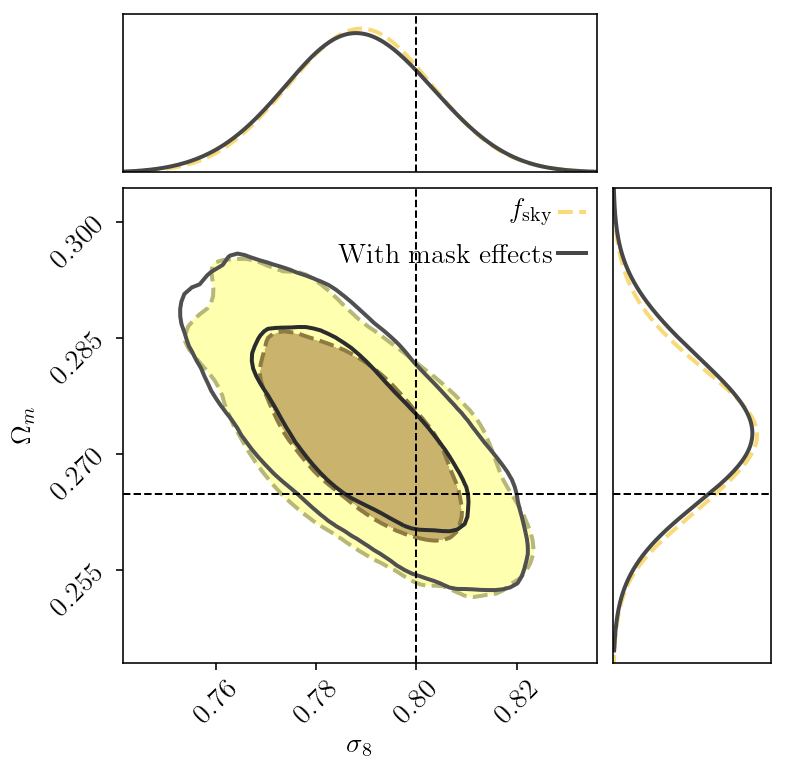

In [8]:
# With EMCEE there are no weights
# Cosmo parameters
burnin = 150000

cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo1 = get_indices(chainfile_1, cosmo_parnames)

c = ChainConsumer()
#c.add_chain(chain_0[:,cosmo0], parameters=cosmo_names_lcdm, name=name_0, weights=chain_0[:,-1])
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(chain_1[burnin:,cosmo1], parameters=cosmo_names, name=name_1)


def call_configure(c):
    c.configure(kde=[3.,3.,2.,2.,1,1,1], shade=[True, False,False,False,True,False, False], shade_alpha=0.9, bar_shade=False,colors=[ colors[3],colors[0]],legend_kwargs={"fontsize": 14},
            legend_color_text=False, tick_font_size=14, label_font_size=14, linewidths=[2., 2., 2.5, 1], linestyles=["--", "-","-", ":","-", "-", "--",":"])
    return c

c = call_configure(c)

fig = c.plotter.plot(figsize=(2.8,2.8), truth=cosmo_truths)
fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_reduced_emcee.png'%(name_plots, burnin), bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_reduced_emcee.pdf'%(name_plots, burnin), bbox_inches="tight")


In [11]:
cosmo0

[28, 29]

In [12]:
cosmo1

[28, 29]

In [27]:
cosmo0 = get_indices(chainfile_0, cosmo_parnames)

In [28]:
cosmo0

[0, 1, 4, 29]

In [29]:
cosmo_parnames

['cosmological_parametersomega_c',
 'cosmological_parametersomega_b',
 'COSMOLOGICAL_PARAMETERSSIGMA_8cosmological_parametersn_s',
 'cosmological_parametersh0',
 'COSMOLOGICAL_PARAMETERSOMEGA_M']